In [31]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import Fully_connected_network as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [32]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

torch.manual_seed(12)
torch.set_default_dtype(torch.float64)

Running on the GPU


In [33]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [34]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [94]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        self.u_scale = torch.max(torch.abs(u_train))/2
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func) 
        self.model_optimizer = 'defined in train'
        self.loss_criterion = 'defined in train'

    def _adam_train(self, n_iter):
        loss_criterion = self.loss_criterion
        model_optimizer = self.model_optimizer

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train) * self.loss_scale
            loss_value.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def _closure(self):
        self.model_optimizer.zero_grad()
        u_pred = self.model(self.x_train)
        loss_value = self.loss_criterion(u_pred, self.u_train) * self.loss_scale
        loss_value.backward()
        return loss_value
    
    def _lbfgs_train(self, n_iter):
        for iter_i in range(n_iter):
            loss_value = self.model_optimizer.step(self._closure)
            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value}")

    def train(self, n_iter, method):
        self.loss_criterion = torch.nn.MSELoss()
        if method == 1:
            self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
            self._adam_train(n_iter)
        elif method == 2:
            self.model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.1, max_iter=n_iter//3, tolerance_grad=1e-11, line_search_fn='strong_wolfe')
            self._lbfgs_train(n_iter)

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred



In [76]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1)
u_eval = u_exact(x_eval)

In [91]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(5000, 1)
model1.train(1000, 2)
u_pred = model1.predict(x_eval)

Iteration 0, Loss: 0.8319986308748906
Iteration 100, Loss: 0.053011407141506824
Iteration 200, Loss: 0.010090105253185646
Iteration 300, Loss: 0.006366835317027411
Iteration 400, Loss: 0.005356356053696975
Iteration 500, Loss: 0.004425660731995338
Iteration 600, Loss: 0.0035285851301404343
Iteration 700, Loss: 0.0026957131301112765
Iteration 800, Loss: 0.0019874031712016184
Iteration 900, Loss: 0.0014367160356047281
Iteration 1000, Loss: 0.0010343905816144752
Iteration 1100, Loss: 0.0007491799731094655
Iteration 1200, Loss: 0.0005481875834763677
Iteration 1300, Loss: 0.00040540243843563173
Iteration 1400, Loss: 0.0003025543070070675
Iteration 1500, Loss: 0.00022738809453184866
Iteration 1600, Loss: 0.00017175880391561045
Iteration 1700, Loss: 0.00013019742902558066
Iteration 1800, Loss: 9.895646748945773e-05
Iteration 1900, Loss: 7.540325099681347e-05
Iteration 2000, Loss: 5.7639668293746285e-05
Iteration 2100, Loss: 4.4263485086704515e-05
Iteration 2200, Loss: 3.42541392896024e-05
Ite

In [92]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train).detach()
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(10000, 1)
model2.train(1000, 2)
u_pred2 = model2.predict(x_eval)
u_p = u_pred + u_pred2

Iteration 0, Loss: 1.0122376008223155e-06
Iteration 100, Loss: 4.5646333696765816e-09
Iteration 200, Loss: 1.9682498854505912e-09
Iteration 300, Loss: 1.1520686081007883e-09
Iteration 400, Loss: 7.427609224574785e-10
Iteration 500, Loss: 5.086904723465687e-10
Iteration 600, Loss: 3.6413903220425964e-10
Iteration 700, Loss: 2.697755543520854e-10
Iteration 800, Loss: 2.0686455821164631e-10
Iteration 900, Loss: 1.6452006289842564e-10
Iteration 1000, Loss: 1.3558001198432084e-10
Iteration 1100, Loss: 1.1530057616810619e-10
Iteration 1200, Loss: 1.0061328008323994e-10
Iteration 1300, Loss: 8.957276383666347e-11
Iteration 1400, Loss: 8.09583581870268e-11
Iteration 1500, Loss: 7.400406192790451e-11
Iteration 1600, Loss: 6.822437535641818e-11
Iteration 1700, Loss: 6.330579023372723e-11
Iteration 1800, Loss: 5.904063274703968e-11
Iteration 1900, Loss: 5.5287144041537556e-11
Iteration 2000, Loss: 5.194540863096611e-11
Iteration 2100, Loss: 4.894272889825016e-11
Iteration 2200, Loss: 4.6224609501

In [95]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach()
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(5000, 1)
model3.train(1000, 2)
u_pred3 = model3.predict(x_eval)
u_p2 = u_p + u_pred3

Iteration 0, Loss: 9.966873337095923e-11
Iteration 100, Loss: 6.671986846744702e-11
Iteration 200, Loss: 5.864237716752894e-11
Iteration 300, Loss: 4.851232681008375e-11
Iteration 400, Loss: 3.3614467782713e-11
Iteration 500, Loss: 2.2764623902198353e-11
Iteration 600, Loss: 1.5943870061768785e-11
Iteration 700, Loss: 1.243591295447202e-11
Iteration 800, Loss: 1.0610356008444338e-11
Iteration 900, Loss: 9.544404596139058e-12
Iteration 1000, Loss: 8.852648417201526e-12
Iteration 1100, Loss: 8.367990121237915e-12
Iteration 1200, Loss: 8.0082801262146e-12
Iteration 1300, Loss: 7.728476940790556e-12
Iteration 1400, Loss: 7.502086252935978e-12
Iteration 1500, Loss: 7.312813366273028e-12
Iteration 1600, Loss: 7.15030631263495e-12
Iteration 1700, Loss: 7.0077940017198966e-12
Iteration 1800, Loss: 6.880711472210725e-12
Iteration 1900, Loss: 6.765880092811247e-12
Iteration 2000, Loss: 6.661012261063895e-12
Iteration 2100, Loss: 6.564408936533792e-12
Iteration 2200, Loss: 6.474772425588769e-12
I

In [96]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(5000, 1)
model4.train(1000, 2)
u_pred4 = model4.predict(x_eval)

u_p3 = u_p2 + u_pred4

Iteration 0, Loss: 9.190015745987566e-11
Iteration 100, Loss: 4.121971640015139e-11
Iteration 200, Loss: 3.1127660257554174e-11
Iteration 300, Loss: 2.6073050867193833e-11
Iteration 400, Loss: 2.2809325795326764e-11
Iteration 500, Loss: 2.0229690327592267e-11
Iteration 600, Loss: 1.7972854416434935e-11
Iteration 700, Loss: 1.5919450279067947e-11
Iteration 800, Loss: 1.4069908769988232e-11
Iteration 900, Loss: 1.2491592437887233e-11
Iteration 1000, Loss: 1.1229837822370424e-11
Iteration 1100, Loss: 1.0246112373745426e-11
Iteration 1200, Loss: 9.458191936703492e-12
Iteration 1300, Loss: 8.79887554219849e-12
Iteration 1400, Loss: 8.228684752694641e-12
Iteration 1500, Loss: 7.725976883914749e-12
Iteration 1600, Loss: 7.277773875316264e-12
Iteration 1700, Loss: 6.875142190401489e-12
Iteration 1800, Loss: 6.511320371475151e-12
Iteration 1900, Loss: 6.181013488579957e-12
Iteration 2000, Loss: 5.880081501052937e-12
Iteration 2100, Loss: 5.6053224388991255e-12
Iteration 2200, Loss: 5.3542641269

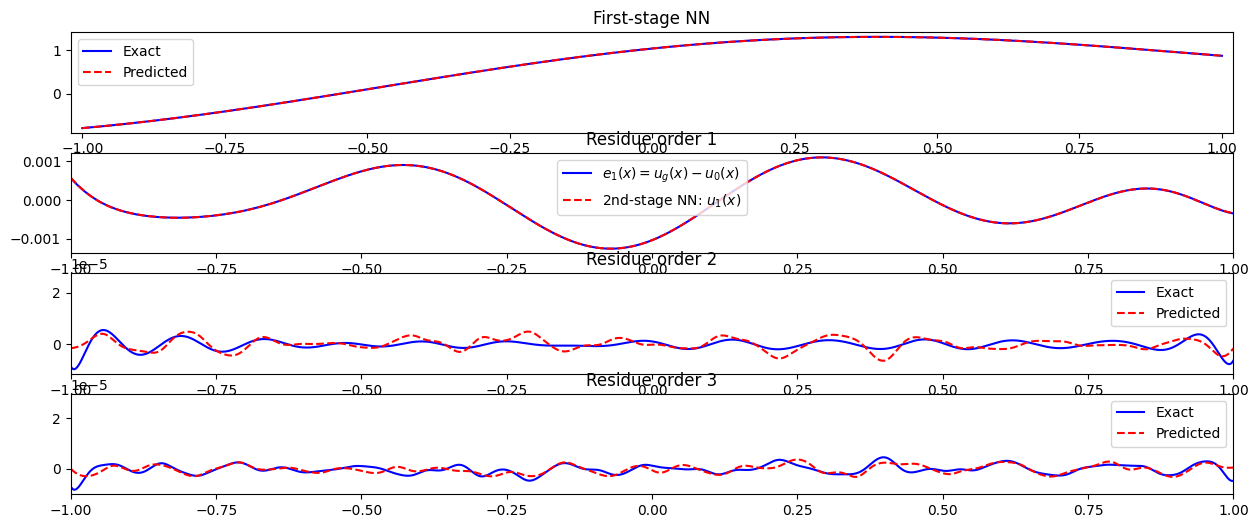

In [97]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
axes[0].plot(x_eval, u_eval, 'b-', label='Exact')
axes[0].plot(x_eval, u_pred.detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain, up_bound_xtrain)
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train, u_train2.detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval, u_pred2.detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening, u_train3, 'b-', label='Exact')
axes[2].plot(x_eval, u_pred3.detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening, u_train4.detach(), 'b-', label='Exact')
axes[3].plot(x_eval, u_pred4.detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [98]:
import numpy as np 
error_u = np.linalg.norm(u_eval - u_pred.detach())/np.linalg.norm(u_eval, 2)
error_u2 = np.linalg.norm(u_eval - u_p2.detach())/np.linalg.norm(u_eval, 2)
error_u3 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)
error_u4 = np.linalg.norm(u_eval - u_p3.detach())/np.linalg.norm(u_eval, 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0006663888753497176
Error of order 2: 2.007293584962915e-06
Error of order 3: 1.445865903111398e-06
Error of order 4: 1.445865903111398e-06
